<h1 style="padding-top: 25px;padding-bottom: 25px;text-align: left; padding-left: 10px; background-color: #DDDDDD; 
    color: black;"> <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> AC295: Advanced Practical Data Science </h1>

## Transfer Learning for Text & Word Embeddings

**Harvard University, Fall 2020**  
**Instructors**: Pavlos Protopapas  

---

**Each assignment is graded out of 5 points.  The topic for this assignment is Transfer Learning for Text.**

**Due:** 10/27/2020 10:15 AM EDT

**Submit:** We won't be re running your notebooks, please ensure output is visible in the notebook.

#### Learning Objectives

In this exercise you will cover the following topics:  
- Tokenizing text using Text Vectorization
- Perform text classification & create word emedddings
- Load pre-trained word embeddings and perform text classification
- Understand Word Embeddings

---

#### Imports

In [ ]:
import os
import requests
import zipfile
import tarfile
import shutil
import json
import time
import sys
import string
import re
import numpy as np
import pandas as pd
from glob import glob
from string import Template
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.python.ops import io_ops
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

#### Verify Setup

In [ ]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.3.0
keras version 2.4.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### Utils

In [ ]:
def download_file(packet_url, base_path="", extract=False):
  if base_path != "":
    if not os.path.exists(base_path):
      os.mkdir(base_path)
  packet_file = os.path.basename(packet_url)
  with requests.get(packet_url, stream=True) as r:
      r.raise_for_status()
      with open(os.path.join(base_path,packet_file), 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)
  
  if extract:
    if packet_file.endswith(".zip"):
      with zipfile.ZipFile(os.path.join(base_path,packet_file)) as zfile:
        zfile.extractall(base_path)
    
    if packet_file.endswith(".tar.gz"):
      packet_name = packet_file.split('.')[0]
      with tarfile.open(os.path.join(base_path,packet_file)) as tfile:
        tfile.extractall(base_path)

def evaluate_model(model,test_data, training_results):
    
  # Get the model train history
  model_train_history = training_results.history
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history["loss"])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in ["loss","val_loss"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()
  
  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in ["accuracy","val_accuracy"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()
  
  # Evaluate on test data
  evaluation_results = model.evaluate(test_data)
  print("Evaluation Results:", evaluation_results)

## Dataset

#### Download

In [ ]:
start_time = time.time()
download_file("https://storage.googleapis.com/dataset_store/ac295/news300.zip", base_path="datasets", extract=True)
download_file("https://github.com/shivasj/dataset-store/releases/download/v3.0/glove.6B.100d.txt.zip", base_path="embedding", extract=True)
execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)

Download execution time (mins) 0.08569519917170207


#### Explore

In [ ]:
data_dir = os.path.join("datasets","news300")
label_names = os.listdir(data_dir)

# Number of unique labels
num_classes = len(label_names) 
# Create label index for easy lookup
label2index = dict((name, index) for index, name in enumerate(label_names))
index2label = dict((index, name) for index, name in enumerate(label_names))

print("Number of classes:", num_classes)
print("Labels:", label_names)

# Generate a list of labels and path to text
data_x = []
data_y = []

for label in label_names:
  text_files = os.listdir(os.path.join(data_dir,label))
  data_x.extend([os.path.join(data_dir,label,f) for f in text_files])
  data_y.extend([label for f in text_files])

# Preview
print("data_x count:",len(data_x))
print("data_y count:",len(data_y))
print(data_x[:5])
print(data_y[:5])

# sns.countplot()
# plt.show()
np.unique(data_y, return_counts=True)

Number of classes: 3
Labels: ['politics', 'health', 'entertainment']
data_x count: 920
data_y count: 920
['datasets/news300/politics/182.txt', 'datasets/news300/politics/96.txt', 'datasets/news300/politics/132.txt', 'datasets/news300/politics/19.txt', 'datasets/news300/politics/68.txt']
['politics', 'politics', 'politics', 'politics', 'politics']


(array(['entertainment', 'health', 'politics'], dtype='<U13'),
 array([310, 310, 300]))

#### View Text

In [ ]:
# Generate a random sample of index
data_samples = np.random.randint(0,high=len(data_x)-1, size=10)
for i,data_idx in enumerate(data_samples):
  # Read text
  txt = io_ops.read_file(data_x[data_idx])

  print("Label:",data_y[data_idx],", Text:",txt.numpy())

Label: entertainment , Text: b'Jon Stewart tackles the union of money and politics in \'Irresistible\'  (CNN)Jon Stewart resurfaces with a politically savvy directorial effort, "Irresistible," that\'s a bit too heavy-handed to live up to its title. Delving into the corrosive influence of money on politics, Stewart\'s second film exhibits passion for its topic and cleverly registers an important point before it\'s over, but labors too much getting there. Reunited with his one-time "The Daily Show" colleague Steve Carell, Stewart picks off (and on) familiar targets. That begins with media excesses, from the hosts on Fox News to glimpses of a CNN panel with more pundits sharing the screen than "Hollywood Squares." The main focus, however, is on political gamesmanship, embodied by consultant Gary Zimmer, played by Carell. Shown in pictures alongside Bill Clinton, it\'s clear he possesses juice in Democratic circles, which makes his latest mission unlikely. Zimmer has identified a Wisconsin

#### Build Data Pipelines

##### Text Vectorization

[Reference](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization)

Generate Text Vector:
- Standardize each sample (usually lowercasing + punctuation stripping)
- Split each sample into substrings (usually words)
- Recombine substrings into tokens (usually ngrams)
- Index tokens (associate a unique int value with each token)
- Transform each sample using this index, either into a vector of ints or a dense float vector

In [ ]:
# Text Vectorization
def standardize_text(input_text):
  # Convert to lowercase
  lowercase = tf.strings.lower(input_text)
  # Remove HTML tags
  stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
  return tf.strings.regex_replace(
      stripped_html, "[%s]" % re.escape(string.punctuation), ""
  )

# Load Text
def load_text(path, label=None):
  text = io_ops.read_file(path)
  if label is None:
    return text
  else:
    return text, label

# Feature constraints
max_features = 15000
sequence_length = 1000

# Initialize Text Vectorizer
text_vectorizer = TextVectorization(
    standardize=standardize_text,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

# Create the vocabulary of entire dataset
text_data = tf.data.Dataset.from_tensor_slices(data_x)
text_data = text_data.map(load_text, num_parallel_calls=AUTOTUNE)

# Generate Text Vector
start_time = time.time()
text_vectorizer.adapt(text_data.batch(64))
execution_time = (time.time() - start_time)/60.0
print("Execution time (mins)",execution_time)

# Get Vocabulary
vocabulary = text_vectorizer.get_vocabulary()
vocabulary_size = len(vocabulary)
print("Vocabulary Size:",vocabulary_size)
# Generate word index
word_index = dict(zip(vocabulary, range(vocabulary_size)))

Execution time (mins) 0.010395503044128418
Vocabulary Size: 15000


In [ ]:
# Check Vocabulary : 0 is reserved for padding and index 1 is reserved for "out of vocabulary" tokens
print("Vocabulary:",vocabulary[:20])
print("Vocabulary Size:",len(vocabulary))

# Test our text vectorizer
test_text = txt = io_ops.read_file(data_x[data_samples[0]])
print(test_text)
test_text_vector = text_vectorizer([test_text.numpy()])
print("Shape:",test_text_vector.shape)
print(test_text_vector[0,:20])

Vocabulary: ['', '[UNK]', 'the', 'to', 'and', 'of', 'a', 'in', 'that', 'for', 'is', 'on', 'said', 'with', 'as', 'it', 'have', 'are', 'be', 'at']
Vocabulary Size: 15000
tf.Tensor(b'Jon Stewart tackles the union of money and politics in \'Irresistible\'  (CNN)Jon Stewart resurfaces with a politically savvy directorial effort, "Irresistible," that\'s a bit too heavy-handed to live up to its title. Delving into the corrosive influence of money on politics, Stewart\'s second film exhibits passion for its topic and cleverly registers an important point before it\'s over, but labors too much getting there. Reunited with his one-time "The Daily Show" colleague Steve Carell, Stewart picks off (and on) familiar targets. That begins with media excesses, from the hosts on Fox News to glimpses of a CNN panel with more pundits sharing the screen than "Hollywood Squares." The main focus, however, is on political gamesmanship, embodied by consultant Gary Zimmer, played by Carell. Shown in pictures alo

##### Split Data

In [ ]:
validation_percent = 0.20

# Split data into train / validate
train_x, validate_x, train_y, validate_y = train_test_split(data_x, data_y, test_size=validation_percent)

print("train_x count:",len(train_x))
print("validate_x count:",len(validate_x))

train_x count: 736
validate_x count: 184


##### Create TF Dataset

In [ ]:
batch_size = 64

# Convert all y labels to numbers
train_processed_y = [label2index[label] for label in train_y]
validate_processed_y = [label2index[label] for label in validate_y]

# Converts to y to binary class matrix (One-hot-encoded)
train_processed_y = to_categorical(train_processed_y, num_classes=num_classes, dtype='float32')
validate_processed_y = to_categorical(validate_processed_y, num_classes=num_classes, dtype='float32')

# Vectorize Text
def vectorize_text(text, label=None):
  text = tf.expand_dims(text, -1)
  text = text_vectorizer(text)
  if label is None:
    return text
  else:
    return text, label

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_processed_y))
validation_data = tf.data.Dataset.from_tensor_slices((validate_x, validate_processed_y))

#############
# Train data
#############
# Apply all data processing logic
train_data = train_data.map(load_text, num_parallel_calls=AUTOTUNE)
train_data = train_data.batch(batch_size)
train_data = train_data.map(vectorize_text, num_parallel_calls=AUTOTUNE)
train_data = train_data.cache().prefetch(buffer_size=100)

##################
# Validation data
##################
# Apply all data processing logic
validation_data = validation_data.map(load_text, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.batch(batch_size)
validation_data = validation_data.map(vectorize_text, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.cache().prefetch(buffer_size=100)

print("train_data",train_data)
print("validation_data",validation_data)

train_data <PrefetchDataset shapes: ((None, 1000), (None, 3)), types: (tf.int64, tf.float32)>
validation_data <PrefetchDataset shapes: ((None, 1000), (None, 3)), types: (tf.int64, tf.float32)>


## Questions:

**All data preparation steps have been performed and you can continue to building models in following questions**

Note on dataset input sizes:
```
# Feature constraints
max_features = 15000
sequence_length = 1000
```

## Question 1 : Build a text classification model using FFNN (0.5 Point)

#### a) Build a Text Classification Model

- Build the model using a few `Dense` layers
- Input size is `1000`
- Do **NOT** use the `Embedding` layer in your model
- Use `categorical_crossentropy` loss
- Ensure there is a plot of your training history

In [ ]:
inputs = tf.keras.Input(shape=(None, sequence_length))
x = layers.Dense(128, activation='relu')(inputs)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dropout(0.2)(x)
predictions = layers.Dense(3, activation='softmax', name='predictions')(x)
model = tf.keras.Model(inputs, predictions)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()
epochs = 100
training_results = model.fit(train_data, validation_data=validation_data, epochs=epochs)

evaluate_model(model, validation_data, training_results)

#### b) How is the performance of your model?



```
# This is formatted as code
```

*Your answer here*

the validation accurancy plateau at `0.42`, barely better than the baseline of `0.33`.

the reasons are as follows:
1. we are not using one of the textual techniques, such as `rnn` or `lstm`, so that we can't derive meanings from the context, to name just one of the drawbacks
2. the text features will take a lot of processing to learn. have a somewhat shallow neural net with < 200K weights are not going to suffice. 

this points to natually transfer learning, where the text features have already been learned.

## Question 2 : Build a text classification model with embeddings (1.0 Point)

#### a) Preliminary Questions 

- Explain what is the purpose of the `Embedding` Layer ? 
- Name two reasons why using one-hot encoded vectors instead is not the way to go
- Explain what the inputs and outputs of the `Embedding` Layer are. Also comment on the dimension going in and what is coming out


*Your answer here*

1. the embedding layer esssentially assigns a vector (embedding) to each word, which hopefully captures and represents the meaning of a word. in this sense, the related or similar words will be closer together, whereas the distant words will be far apart.
2. the reason one-hot embedding is not the way to go 

   1. it will result in huge-dimensional data that the input large and sparse and unsuitable for extracting features. for example, with a vocabulary sized at 15000, it will result in a 15000 * 1000 = 15M matrix to just represent a text. it is not practical for computation.
   2. one-hot also doesn't capture the meaning of a word and it can not be trained in the neural network.

3. the input of the embedding layer will be a 1000-element vector, with each element representing a word in the text. the output will be a 768 * 1000 matrix (assuming the embedding size is 768, which may for some embeddings 1024 or others) 

#### b) Build a Text Classification Model

- You need to include the `Embedding` layer in your model
- Following the `Embedding` layer you can use `Conv1D` or `LSTM`
- Use loss of `categorical_crossentropy`
- Ensure there is a plot of your training history



Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         1500000   
_________________________________________________________________
dropout_11 (Dropout)         (None, None, 100)         0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 100)         70100     
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 100)         70100     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 100)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 100)             

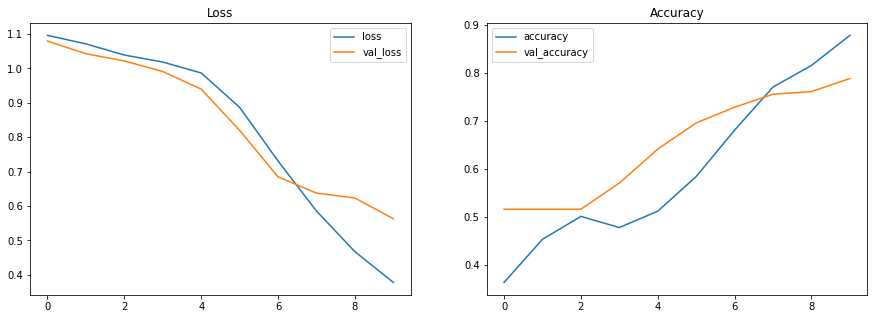

3/3 [==============================] - 0s 8ms/step - loss: 0.5628 - accuracy: 0.7880
Evaluation Results: [0.5628077387809753, 0.7880434989929199]


In [ ]:
# inputs = tf.keras.Input(shape=(None, sequence_length))
embedding_dim = 100

inputs = tf.keras.Input(shape=(None,))

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim, name="embedding")(inputs)
x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = layers.Conv1D(embedding_dim, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Conv1D(embedding_dim, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(embedding_dim, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(3, activation="softmax", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()
epochs = 10
training_results = model.fit(train_data, validation_data=validation_data, epochs=epochs)

evaluate_model(model, validation_data, training_results)


#### c) Save Embedding layer weights

- Save the weights of your embedding layer
- The weights will be used in Question 4
- Feel free to use the code below to extract layer weights

```
# Get the Embedding Layer
embedding_layer_no_tl = model.get_layer(name="embedding")
embedding_layer_no_tl_weights = embedding_layer_no_tl.get_weights()[0]
print(embedding_layer_no_tl_weights.shape)
```

In [ ]:
embedding_layer_no_tl = model.get_layer(name="embedding")
embedding_layer_no_tl_weights = embedding_layer_no_tl.get_weights()[0]
print(embedding_layer_no_tl_weights.shape)

(15000, 100)


---

## Question 3 : Build a text classification model with pre-trained embeddings (2.5 Point)

#### a) Preliminary Questions 


- How is using pre-trained word embedding adding knowledge to the model? (Use an example if needed) 

- Provide a scenario where retraining the pre-trained embedding layer may be needed

*Your answer here*

1. Word Embeddings are vectors that represent the meanings of various words. Pretrained Word Embeddings are the embeddings learned in one task that are used for solving another similar task. With the limited training data that we have, it is close to impossbile to derive complete meanings. Word2Vec and GloVe are pretrained on a very large corpus so that it should be more accurate in capturing the meanings of various words. 
2. Retrain the pretrained embedding may be needed for domains where common words have specialized meanings. for example, normally the word `python` means a snake, but if the corpus is computer science and programming, then the word mostly likely means computer programming language. in which case, retrain your model in the computer science corpus will help. 


#### b) Build a Text Classifcation Model using pre-trained word embeddings

- Build a Text Classification Model
- You need to include the `Embedding` layer in your model
- The `Embedding` layer should have its weights loaded from any **pre-trained word embeddings** such as Glove, Word2Vec, FastText etc.
- [Example](https://medium.com/@ppasumarthi_69210/word-embeddings-in-keras-be6bb3092831) of how to load pre-trained word embeddings for Word2Vec
- [Example](https://keras.io/examples/nlp/pretrained_word_embeddings/) of how to load pre-trained word embeddings for Glove
- [Example](https://www.kaggle.com/vsmolyakov/keras-cnn-with-fasttext-embeddings) of how to load pre-trained word embeddings for FastText
- Make the `Embedding` layer as `trainable=False`
- Following the `Embedding` layer you can use `Conv1D` or `LSTM`
- Use loss of `categorical_crossentropy`
- Ensure there is a plot of your training history

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2020-10-24 14:04:26--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-10-24 14:04:26--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-10-24 14:04:26--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
embeddings_index = {}
with open('glove.6B.100d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

embedding_dim = len(embeddings_index['hello'])

In [ ]:
embedding_matrix = np.zeros((max_features, embedding_dim))
hits, misses = 0, 0
for i, word in enumerate(vocabulary):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1

print("Converted %d words (%d misses)" % (hits, misses))

from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    max_features,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

Converted 14094 words (906 misses)


Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 100)         1500000   
_________________________________________________________________
dropout_9 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 768)         538368    
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 768)         4129536   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 768)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 768)             

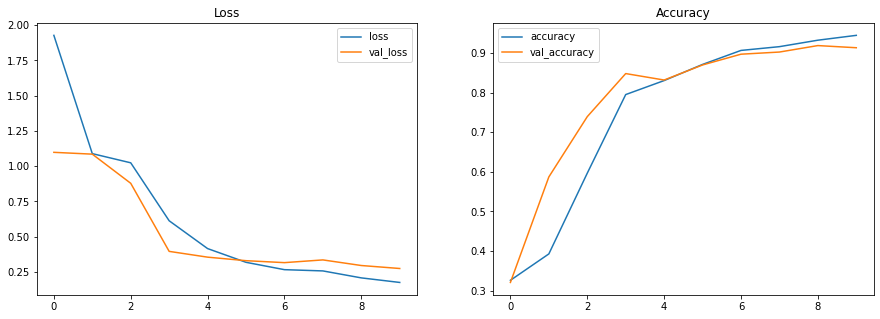

3/3 [==============================] - 0s 17ms/step - loss: 0.2740 - accuracy: 0.9130
Evaluation Results: [0.27404549717903137, 0.9130434989929199]


In [ ]:
embedding_dim = 768

inputs = tf.keras.Input(shape=(None,))

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
# x = embedding_layer(max_features, embedding_dim, name="embedding")(inputs)
x = embedding_layer(inputs)
x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = layers.Conv1D(embedding_dim, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Conv1D(embedding_dim, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(embedding_dim, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(3, activation="softmax", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()
epochs = 10
training_results = model.fit(train_data, validation_data=validation_data, epochs=epochs)

evaluate_model(model, validation_data, training_results)


#### c) Save Embedding layer weights

- Save the weights of your embedding layer
- The weights will be used in Question 4
- Feel free to use the code below to extract layer weights

```
# Get the Embedding Layer
embedding_layer_tl = model.get_layer(name="embedding")

embedding_layer_tl_weights = embedding_layer_tl.get_weights()[0]
print(embedding_layer_tl_weights.shape)
```

In [ ]:
embedding_layer_tl = model.layers[1]
 
embedding_layer_tl_weights = embedding_layer_tl.get_weights()[0]
print(embedding_layer_tl_weights.shape)

(15000, 100)


---

## Question 4 : Analysing Word Embeddings (1.0 Point)

Feel free to use these functions for this question:

```
def find_similar(words, word_index, vocabulary, embedding_layer_weights, topn=5):
  subset_word_index  = []
  for word in words:
    subset_word_index.append(word_index[word])
  
  cs_op = cosine_similarity(embedding_layer_weights[subset_word_index], embedding_layer_weights)
  for idx in range(len(words)):
    top = cs_op[idx].argsort()[-topn:][::-1]
    for i,t in enumerate(top):
      if i ==0:
        print("Similar words for:",vocabulary[t])
      else:
        print("    ",vocabulary[t])

def find_analogy(word_a, word_b, word_c, word_index, vocabulary, embedding_layer_weights, topn=5):
  idx_a = word_index[word_a]
  idx_b = word_index[word_b]
  idx_c = word_index[word_c]

  # Vectors
  vec_a = embedding_layer_weights[idx_a]
  vec_b = embedding_layer_weights[idx_b]
  vec_c = embedding_layer_weights[idx_c]

  op = vec_b - vec_a + vec_c
  cs_op = cosine_similarity([op], embedding_layer_weights)
  top = cs_op[0].argsort()[-topn:][::-1]

  print(word_b,"-",word_a,"+", word_c, "=")
  for i,t in enumerate(top):
    print("   ",vocabulary[t])
```

#### a) Finding Semantically similar words

- We want to find words that are semantically similar to the following words: ```['covid19','election','2020','pandemic','quarantine']```
- Run the function `find_similar(...)` and display the results for embedding weights from question 2 and question 3

In [ ]:
def find_similar(words, word_index, vocabulary, embedding_layer_weights, topn=5):
  subset_word_index  = []
  for word in words:
    subset_word_index.append(word_index[word])
 
  cs_op = cosine_similarity(embedding_layer_weights[subset_word_index], embedding_layer_weights)
  for idx in range(len(words)):
    top = cs_op[idx].argsort()[-topn:][::-1]
    for i,t in enumerate(top):
      if i ==0:
        print("Similar words for:",vocabulary[t])
      else:
        print("    ",vocabulary[t])
 
def find_analogy(word_a, word_b, word_c, word_index, vocabulary, embedding_layer_weights, topn=5):
  idx_a = word_index[word_a]
  idx_b = word_index[word_b]
  idx_c = word_index[word_c]
 
  # Vectors
  vec_a = embedding_layer_weights[idx_a]
  vec_b = embedding_layer_weights[idx_b]
  vec_c = embedding_layer_weights[idx_c]
 
  op = vec_b - vec_a + vec_c
  cs_op = cosine_similarity([op], embedding_layer_weights)
  top = cs_op[0].argsort()[-topn:][::-1]
 
  print(word_b,"-",word_a,"+", word_c, "=")
  for i,t in enumerate(top):
    print("   ",vocabulary[t])

In [ ]:
words = ['covid19','election','2020','pandemic','quarantine']

find_similar(words, word_index, vocabulary, embedding_layer_no_tl_weights, topn=5)

Similar words for: covid19
     emergency
     researchers
     infection
     kerkhove
Similar words for: election
     utha
     biden
     pledge
     immunity
Similar words for: 2020
     methodology
     bethesda
     monthslong
     ruth
Similar words for: pandemic
     great
     7th
     exchanged
     restrictions
Similar words for: quarantine
     visiting
     percentage
     désert
     cnnhouse


In [ ]:
find_similar(words, word_index, vocabulary, embedding_layer_tl_weights, topn=5)

Similar words for: oldest
     steroid
     skeptical
     slowed
     solely
Similar words for: election
     elections
     vote
     polls
     electoral
Similar words for: 2020
     2015
     2050
     2030
     2017
Similar words for: pandemic
     influenza
     flu
     epidemic
     h1n1
Similar words for: quarantine
     inspection
     quarantined
     sars
     poultry


- Explain your results, does the similar words have any real world similarity?
- Explain the results of the word `covid19` from learned embeddings weights vs pre-trained embeddings weights



```
# This is formatted as code
```

*Your answer here*

it appears that the words have real world similarity in GloVe's case, except the new words, such as `Covid`. the trained embedding is not accurate at all, except for `election` and `covid`

this indicates that the accurancy and relevancy of embeddings has a lot to do with the data that it was trained on. the principle is that the more and the more up-to-date, the more effective/accurate the embeddings are.

`covid19` is not in the vocabulary of pretrained embedding GloVe before the embeddings were trained prior to Covid 19. so while the pretrained embedding just doesn't return anything meaningful, the embedding that is training by the latest news artciles are able to return some very relative results.


#### b) Finding Analogies

- Word embeddings can be used to find analogies between words. For example, “man” is to “woman” as “son” is to “daughter” is an example of analogy, 
- Let us verify the `male-female` analogy
- Run the function `find_analogy(...)` and display the results for embedding weights from question 2 and question 3

In [ ]:
#find_analogy('man', 'woman', 'son',...) for learned embeddings weights

find_analogy('man', 'woman', 'son', word_index, vocabulary, embedding_layer_no_tl_weights, topn=5)


woman - man + son =
    woman
    son
    playwright
    firsthand
    rachel


In [ ]:
find_analogy('man', 'woman', 'son', word_index, vocabulary, embedding_layer_tl_weights, topn=5)


woman - man + son =
    daughter
    son
    wife
    mother
    father


- Explain your results, does word analogies work in both cases?

*Your answer here*

the word analogy works quite well with the pretrained embedding, because the pretrained embedding is more accurate, whereas the non-pretrained one is less so because it didn't have enough training data to capture the relationships and accurate vector representation of each word.

